# Credit Card Fraud Detection
## Wykrywanie oszustw związanych z kartami kredytowymi


Analizie zostanie poddany zbiór danych zawierający transakcje dokonane kartami kredytowymi we wrześniu 2013r. przez europejczyków w ciągu 2 dni.

Celem zadania jest:

     1) Dokonaj eksploracyjnej analizy danych oraz opisz wnioski i obserwacje;
     2) Stwórz model predykcyjny, który w skuteczny sposób będzie wskazywał podejrzane transakcje;
     3) Dokonać analizy wyników 
     
 Dane pobrane ze strony: https://www.kaggle.com/mlg-ulb/creditcardfraud

## Library - biblioteki 
Wszystkie biblioteki potrzebne do prawidłowego działania kodu znajdują się tutaj.

In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, accuracy_score

import warnings
warnings.filterwarnings("ignore")

## 1) Introduction - Wprowadzenie 

Na podstawie informacji znajdujących się przy danych wiemy, że tabela zawiera 31 kolumn z pośród których możemy wyszczególnić: 
    - Time - liczba sekund, która upłyneła między badaną tranzakcją a pierwszą transakcją w zestawieniu;
    - Kwota - kwota tranzakcji;
    - Klasa - 1 w przypadku oszustwa, 0 w pozostałych przypadkach
    - V1-V28 - przeskalowane, nieopisane dane w celu ochrony danych osobowych
I każda z kolumn zawiera 284807 wierszy.

## 2) First look on the data - Podstawowa analiza danych 
### Podsumowanie zdobytych informacji
    1) Rozmiar danych 284807 wierszy, 31 kolumn
    2) 492(0.1723%) transakcje to oszustwa, a pozostałe 284315(99.823%) transakcji to prawidłowe transakcje
    3) Dane nie zawierają żadnych wybrakowanych wartości.
    4) Analiza histogramu oraz boxplota dla zmiennej "Amount" wynika, że mamy doczynienia z bardzo dużą liczbą małych tranzakcji
    5) Analiza histogramu dla zmiennej "Time" można zauważyć, że podczas dnia jest wykonywane zdecydowanie więcej tranzakcji niż nocą;
    6) Macierz korelacji pokazała, że żadna z kolumn nie jest na tyle skorelowana z Klasą, żeby brać ją pod uwagę.

#### Załadowanie danych 

In [10]:
df = pd.read_csv("Data/creditcard.csv")

In [11]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [12]:
df.shape

(284807, 31)

In [13]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


#### Ilość oszustw 

In [14]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

#### Procentowa ilość oszustw 

In [15]:
print(df.Class.value_counts()[0]/len(df))
print(df.Class.value_counts()[1]/len(df))

0.9982725143693799
0.001727485630620034


#### Ilość outliers

In [26]:
df.isnull().sum().any()

False

#### Histogram

In [17]:
def draw_histogram(data, title, size=(12,5)):
    '''
    EN: Function to plot histogram
    PL:Funkcja do rysowania histogramów
    
    Parameters
    ----------
        data: array, data to visualisation
        title: (str) title of figure
        size: size window, default=(12,5)
    '''       
    fig, ax = plt.subplots(figsize=size)
    sns.distplot(data, ax=ax)
    ax.set_title(title)
    ax.set_xlim([min(data), max(data)])
    plt.show() 

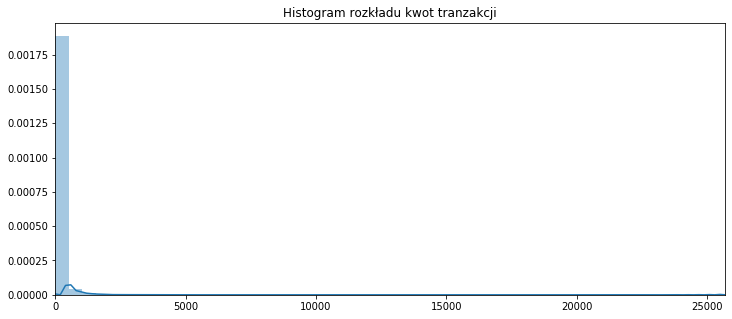

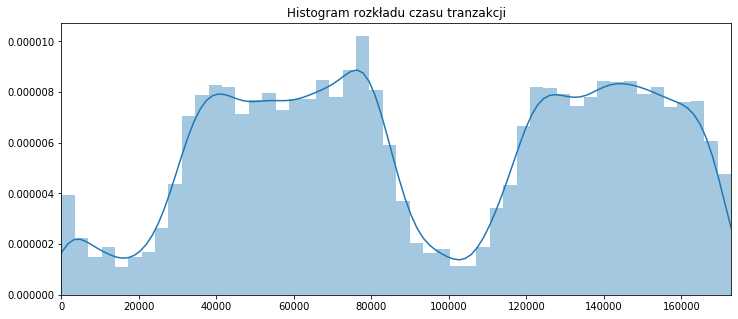

In [18]:
draw_histogram(df.Amount.values, 'Histogram rozkładu kwot tranzakcji')
draw_histogram(df.Time.values, 'Histogram rozkładu czasu tranzakcji')

#### Macierz korelacji 

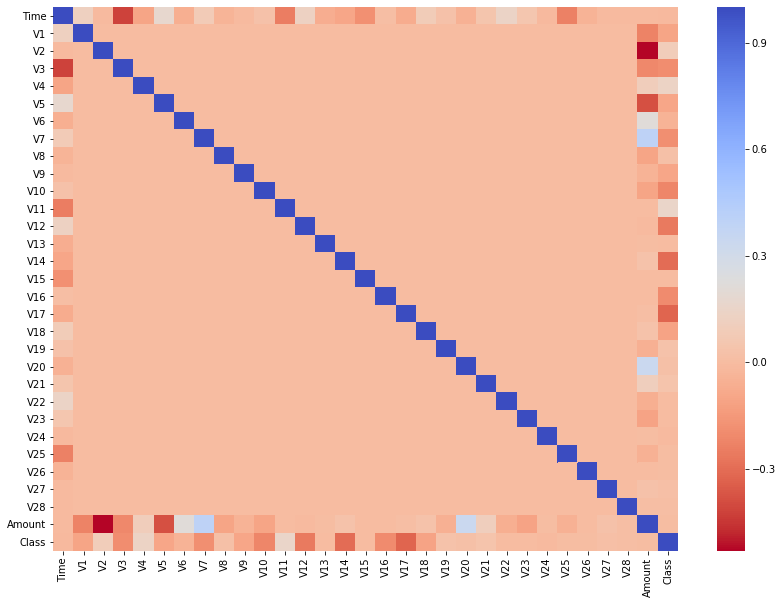

In [19]:
plt.figure(figsize=(14,10))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})

## 3) Preprocessing data 

W tej części skupie się na następujących działaniach:

    1) Przeskalowanie wartości kwot i czasu - ponieważ nasze niewiadome 28 kolumn jest również przeskalowane, to ta czynność jest aż konieczna;
    2) Dostosowanie wielkości danych do wielkości zbioru oszustw - masz mode musi mieć jednakowe szanse na nauczenie się co jest oszustwem, a co nie
    3) Przygotowanie zbiorów treningowych i validacyjnych

#### Skalowanie

In [20]:
std_scaler = StandardScaler()

df['Scaler_amount'] = std_scaler.fit_transform(df.Amount.values.reshape(-1, 1))
df['Scaler_time'] = std_scaler.fit_transform(df.Time.values.reshape(-1, 1))

df.drop(['Time','Amount'], axis=1, inplace=True)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Scaler_amount,Scaler_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


#### Dzielenie danych 

In [21]:
df_sample = df.sample(frac=1)

fraud_df = df_sample[df_sample.Class == 1]
non_fraud_df = df_sample[df_sample.Class == 0]
non_fraud_df = non_fraud_df[:492]
new_df = pd.concat([fraud_df, non_fraud_df])

print(new_df.shape)

new_df.head()

(984, 31)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Scaler_amount,Scaler_time
10568,-5.268053,9.067613,-15.960728,10.296603,-4.708241,-3.395375,-11.161057,5.499963,-5.667376,-11.627194,...,0.191058,0.622928,-1.209264,-0.374799,0.648798,1.584697,0.720056,1,-0.349231,-1.627648
223618,-2.006582,3.676577,-5.463811,7.232058,-1.627859,-0.996755,-4.299833,2.268867,-3.651067,-4.400930,...,-0.063868,0.167947,-0.449864,0.023702,0.536905,0.485864,-0.042393,1,-0.349231,1.024302
248296,-0.613696,3.698772,-5.534941,5.620486,1.649263,-2.335145,-0.907188,0.706362,-3.747646,-4.230984,...,-0.471379,-0.075890,-0.667909,-0.642848,0.070600,0.488410,0.292345,1,-0.353229,1.243705
18466,1.102804,2.829168,-3.932870,4.707691,2.937967,-1.800904,1.672734,-0.300240,-2.783011,-1.884842,...,-0.250050,-0.521627,-0.448950,1.291646,0.516327,0.009146,0.153318,1,-0.350511,-1.374827
9487,-4.153014,8.204797,-15.031714,10.330100,-3.994426,-3.250013,-10.415698,4.620804,-5.711248,-11.797181,...,0.256510,0.485908,-1.198821,-0.526567,0.634874,1.627209,0.723235,1,-0.349231,-1.700235


#### Ja teraz prezentuje się nasza macierz korelacji? 

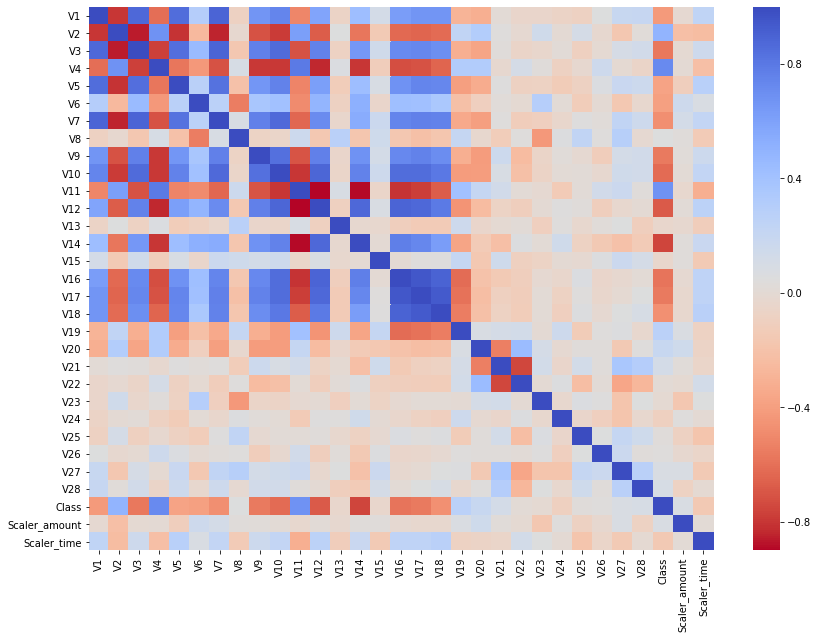

In [22]:
plt.figure(figsize=(14,10))
corr = new_df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})

Można zauważyć, że teraz kolumny V4, V9, V10, V11, V12, V14 i V16 są skorelowane z kolumną Klasy(oszustw)

#### Przygotowanie zbiorów do uczenia 

In [23]:
X_data = new_df.drop('Class', axis=1)
y_data = new_df.Class

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size=0.2, random_state=24601)

##  Classifiers - Klasyfikatory

### Logistic Regression - Regresja logistyczna
#### Training score

In [72]:
classifier = LogisticRegression(random_state=24601)
classifier.fit(X_train, y_train)
training_score_lr = cross_val_score(classifier, X_train, y_train, cv=5)
print("Training score = ", round(training_score_lr.mean(),2)*100, '% accuracy')

Training score =  93.0 % accuracy


#### Confusion matrix

In [74]:
y_pred_lr = classifier.predict(X_test)
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
conf_matrix_lr

array([[87,  5],
       [ 7, 98]], dtype=int64)

####  Looking for the best parameter

In [75]:
lr_parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
                 "penalty": ['l1', 'l2']}
grid_lr = GridSearchCV(classifier, lr_parameters)
grid_lr.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=24601, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [76]:
best_log_regression = grid_lr.best_estimator_
best_log_regression

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=24601, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [77]:
log_regression_score = cross_val_score(best_log_regression, X_train, y_train, cv=5)
print('Logistic Regression -> Cross Validation Score: ', 
      round(log_regression_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression -> Cross Validation Score:  93.52%


### K nearest neighbours - K najbliższych sąsiadów
#### Training score

In [78]:
classifier = KNeighborsClassifier()
classifier.fit(X_train, y_train)
training_score_knears = cross_val_score(classifier, X_train, y_train, cv=5)
print("Training score = ", 
      round(training_score_knears.mean(),2)*100, '% accuracy')

Training score =  94.0 % accuracy


#### Confusion_matrix

In [79]:
y_pred_knears = classifier.predict(X_test)
conf_matrix_knears = confusion_matrix(y_test, y_pred_knears)
conf_matrix_knears

array([[86,  6],
       [11, 94]], dtype=int64)

####  Looking for the best parameter

In [80]:
knears_parameters = {"n_neighbors": [2,3,4,5,6,7], 
                     'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_knears = GridSearchCV(classifier, knears_parameters)
grid_knears.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [81]:
best_knears = grid_knears.best_estimator_
best_knears

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')

In [82]:
knears_score = cross_val_score(best_knears, X_train, y_train, cv=5)
print('K Nearest Neighbours -> Cross Validation Score: ', 
      round(knears_score.mean() * 100, 2).astype(str) + '%')

K Nearest Neighbours -> Cross Validation Score:  93.52%


### Decision Tree  - Drzewa decyzyjne
#### Training score

In [86]:
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)
training_score_tree = cross_val_score(classifier, X_train, y_train, cv=5)
print("Training score = ", 
      round(training_score_tree.mean(),2)*100, '% accuracy')

Training score =  91.0 % accuracy


#### Confusion_matrix

In [87]:
y_pred_tree = classifier.predict(X_test)
conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)
conf_matrix_tree

array([[82, 10],
       [11, 94]], dtype=int64)

#### Looking for the best parameter

In [88]:
tree_parameters = {"criterion": ["gini", "entropy"], 
                   "max_depth": list(range(2,9,1))}
grid_tree = GridSearchCV(classifier, tree_parameters)
grid_tree.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [2, 3, 4, 5, 6, 7, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [89]:
best_trees = grid_tree.best_estimator_
best_trees

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [91]:
tree_score = cross_val_score(best_trees, X_train, y_train, cv=5)
print('Decision Tree -> Cross Validation Score: ', 
      round(tree_score.mean() * 100, 2).astype(str) + '%')

Decision Tree -> Cross Validation Score:  91.61%


## Analysis and summary of collected results - Analiza i podsumowanie zebranych wyników 


### Training Score and  Cross validation score

In [164]:
print('% '*40)
print(' '*10)
print("For Logistic Regression, we got:")
print(' '*10)
print('Training score = ', round(training_score_lr.mean(),5)*100, '% accurasy')
print('Cross validation score = ', round(log_regression_score.mean(),5)*100, '% accurasy')
print(' '*10)
print('% '*40)
print(' '*10)
print("For K nearest neighbours, we got:")
print(' '*10)
print('Training score = ', round(training_score_knears.mean(),5)*100, '% accurasy')
print('Cross validation score = ', round(knears_score.mean(),5)*100, '% accurasy')
print(' '*40)
print('% '*40)
print(' '*10)
print("For Decision Tree, we got:")
print(' '*10)
print('Training score = ', round(training_score_tree.mean(),5)*100, '% accurasy')
print('Cross validation score = ', round(tree_score.mean(),5)*100, '% accurasy')
print(' '*10)
print('% '*40)
print('% '*40)

% % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % 
          
For Logistic Regression, we got:
          
Training score =  93.39 % accurasy
Cross validation score =  93.518 % accurasy
          
% % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % 
          
For K nearest neighbours, we got:
          
Training score =  94.15299999999999 % accurasy
Cross validation score =  93.51899999999999 % accurasy
                                        
% % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % 
          
For Decision Tree, we got:
          
Training score =  91.23599999999999 % accurasy
Cross validation score =  91.613 % accurasy
          
% % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % 
% % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % 


### Confusion matrix

In [135]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          size=5):
    """
    EN: Function to print and plot a confusion matrix
    PL: Funkcja do plotowania tablicy pomyłek 
    
    Parameters
    ----------
        cm: confusion matrix
        classes: type of category
        normalize=False: normalization of number, if you want it, write True
        title: str, title of figure
        cmap: palet of colours
        size: int, width of squere window
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(size,size))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

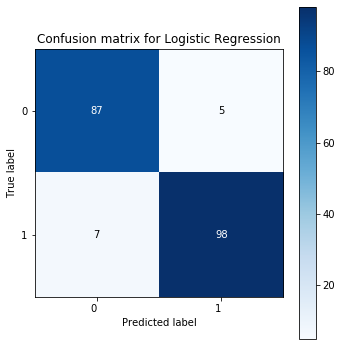

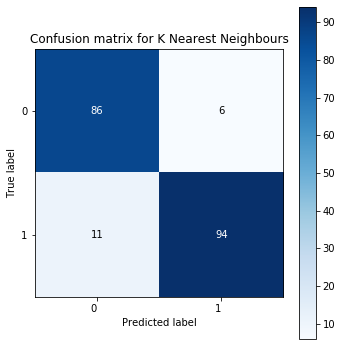

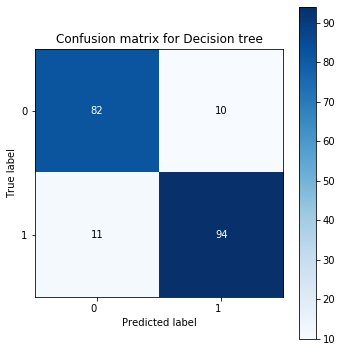

In [136]:
plot_confusion_matrix(conf_matrix_lr, classes=[0,1], 
                      title='Confusion matrix for Logistic Regression')
plot_confusion_matrix(conf_matrix_knears, classes=[0,1], 
                      title='Confusion matrix for K Nearest Neighbours')
plot_confusion_matrix(conf_matrix_tree, classes=[0,1], 
                      title='Confusion matrix for Decision tree')

### Learning curve 

In [138]:
def plot_learning_curve(model, X_data, y_data, cv, 
                        title, n_jobs=1,
                        train_sizes=np.linspace(.1, 1.0, 5),
                        size=(12,5)):
    '''
    EN: Function for drawing a learning curve for training results and cross-validation.
    PL: Funkcja do rysowanie krzywej uczenia dla wyników treninowych oraz cross-validation.
    
    Parameters
    -----------
        model: fitting classifier
        X_data: dataset, with parameters for model
        y_data: dataset, with solution
        cv: int, cross-validation generator or an iterable
        n_jobs: int, Number of jobs to run in parallel
        train_sizes: array, Relative or absolute numbers of training 
                    examples that will be used to generate the learning curve
        size: (int,int), size of figure
    '''
    plt.figure(figsize=(size))
    plt.ylim = (0.80, 1.01)
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_data, y_data, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    plt.title(title)
    plt.xlabel('Training size')
    plt.ylabel('Score')
    plt.grid(True)
    plt.legend(loc="best")

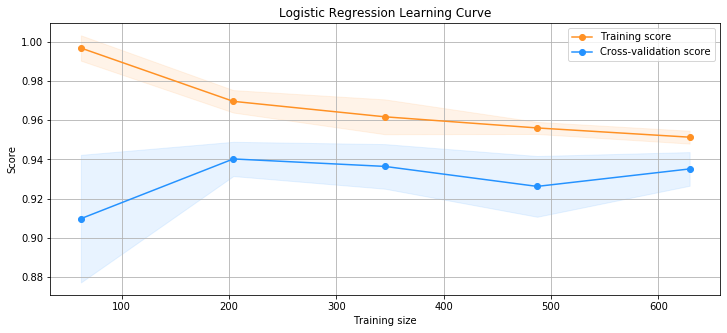

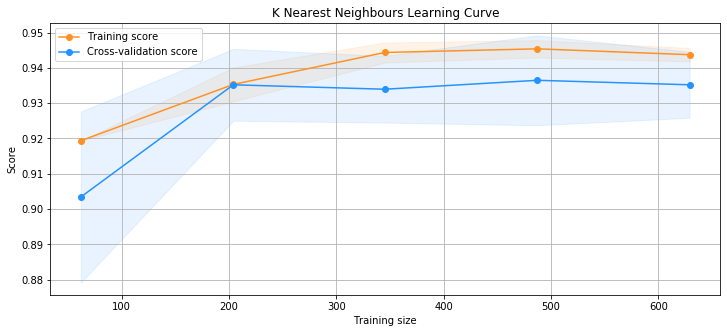

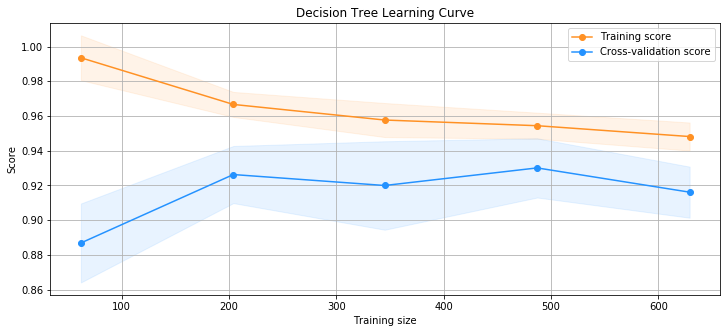

In [139]:
plot_learning_curve(best_log_regression, X_train, y_train, cv=5, title='Logistic Regression Learning Curve')
plot_learning_curve(best_knears, X_train, y_train, cv=5, title='K Nearest Neighbours Learning Curve')
plot_learning_curve(best_trees, X_train, y_train, cv=5, title='Decision Tree Learning Curve')

###  Precision, Recall and F1 score

### ROC_curve 

In [ ]:
def plot_roc_curve(vec_fpr, vec_tpr, vec_label, vec_roc_aus, title):
    '''
    EN: Function to plot many roc_curve on one figure
    PL: Funkcja do rysowania wielu roc_curve na jednym wykresie
    
    Parameters
    ----------
        vec_fpr: array, vector with fpr (false positive rate) for each models
        vec_tpr: array, vector with tpr (true positive rate) for each models
        vec_label: array of str, name models
        vec_roc_aus: array, values roc_auc for each models
        title: str, title of figure 'ROC Curve \n Top 4 Classifiers'
    '''
    plt.figure(figsize=(14,10))
    plt.title(title)
    
    for id_model in len(range(vec_fpr))
        plt.plot(vec_fpr[id_model], vec_tpr[id_model], 
                 label=vec_label + ' Classifier Score: {:.4f}'.format(vec_roc_auc[id_model]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', 
                 xy=(0.5, 0.5), xytext=(0.6, 0.3),
                 arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    plt.show()
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()